In [31]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

In [2]:
df = pd.read_csv("lcdb.csv")
df

,openmlid,learner,size_train,size_test,outer_seed,inner_seed,score_train,score_valid,score_test
0,6,SVC_linear,16,2000,0,0,1.0000,0.1728,0.1840
1,6,SVC_linear,23,2000,0,0,1.0000,0.1939,0.1975
2,6,SVC_linear,32,2000,0,0,1.0000,0.2400,0.2385
3,6,SVC_linear,45,2000,0,0,0.9556,0.2478,0.2515
4,6,SVC_linear,64,2000,0,0,0.9844,0.3150,0.3030
...,...,...,...,...,...,...,...,...,...
1006352,722,sklearn.tree.ExtraTreeClassifier,2896,1500,4,4,1.0000,0.8800,0.8913
1006353,722,sklearn.tree.ExtraTreeClassifier,4096,1500,4,4,1.0000,0.8933,0.8987
1006354,722,sklearn.tree.ExtraTreeClassifier,5793,1500,4,4,1.0000,0.9141,0.9273
1006355,722,sklearn.tree.ExtraTreeClassifier,8192,1500,4,4,1.0000,0.9059,0.8987


In [54]:
import scipy as sp

def get_ipl(sizes, scores):
    def ipl(beta):
        a, b, c = tuple(beta.astype(float))
        pl = lambda x: a - b * x **(-c)
        penalty = []
        for i, size in enumerate(sizes):
            penalty.append((pl(size) - scores[i])**2)
        return np.array(penalty)

    a, b, c = tuple(sp.optimize.least_squares(ipl, np.array([1,1,1]), method="lm").x)
    return a, b, c, lambda x: a - b * x **(-c)

def get_vp(sizes, scores):
    def vp(beta):
        a, b, c = tuple(beta.astype(float))
        fun = lambda x: np.exp(a + b/x + c * np.log(x))
        penalty = []
        for i, size in enumerate(sizes):
            penalty.append((fun(size) - scores[i])**2)
        return np.array(penalty)

    a, b, c = tuple(sp.optimize.least_squares(vp, np.array([1,1,1]), method="lm").x)
    return a, b, c, lambda x: np.exp(a + b/x + c * np.log(x))


def get_mmf(sizes, scores):
    def mmf(beta):
        a, b, c, d = tuple(beta.astype(float))
        fun = lambda x: (a * b + c * x ** d)/(b + x ** d)
        penalty = []
        for i, size in enumerate(sizes):
            penalty.append((fun(size) - scores[i])**2)
        return np.array(penalty)

    a, b, c, d = tuple(sp.optimize.least_squares(mmf, np.array([1,1,1,1]), method="lm").x)
    return a, b, c, d, lambda x: (a * b + c * x ** d)/(b + x ** d)


def get_logpower(sizes, scores):
    def logpower(beta):
        a, b, c = tuple(beta.astype(float))
        fun = lambda x: a / (1 + (x / np.exp(b))**c)
        penalty = []
        for i, size in enumerate(sizes):
            penalty.append((fun(size) - scores[i])**2)
        return np.array(penalty)

    a, b, c = tuple(sp.optimize.least_squares(logpower, np.array([1,1,1]), method="lm").x)
    return a, b, c, lambda x: a / (1 + (x / np.exp(b))**c)

In [103]:
import sklearn.metrics

def get_extrapolation_predictions(df, extrapolation_fun):
    rows = []
    pbar = tqdm(total = len(pd.unique(df["openmlid"])) * len(pd.unique(df["learner"])) * 25)
    for openmlid, df_dataset in df.groupby("openmlid"):
        for learner, df_learner in df_dataset.groupby("learner"):
            for (inner, outer), df_seeded in df_learner.groupby(["inner_seed", "outer_seed"]):
                sizes, scores = df_seeded["size_train"].values, df_seeded["score_valid"].values
                for offset in range(4, len(sizes)):
                    model = extrapolation_fun(sizes[:offset], scores[:offset])[-1]
                    predictions = np.round(model(sizes), 4)
                    rows.append([openmlid, learner, outer, inner, sizes[offset - 1], sizes, scores, predictions])
                pbar.update(1)
    pbar.close()
    return pd.DataFrame(rows, columns=["openmlid", "learner", "outer_seed", "inner_seed", "max_anchor_seen","anchor_prediction", "score", "prediction"])

  0%|          | 0/50000 [00:00<?, ?it/s]

/home/felix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':
/home/felix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in power
  
/home/felix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in double_scalars
  


In [101]:
df_ipl = get_extrapolation_predictions(df.query("inner_seed < 5"), get_ipl)

  0%|          | 0/25 [00:00<?, ?it/s]

In [108]:
#df_1["error"] = [sklearn.metrics.mean_squared_error([y_true], [y_hat]) for y_true, y_hat in zip(df_1["score"], df_1["prediction"])]
df_ipl.to_csv("fit_results_ipl_3.csv", index=False, sep=";")

In [109]:
df_vp = get_extrapolation_predictions(df.query("inner_seed < 5"), get_vp)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [110]:
df_vp.to_csv("fit_results_vp.csv", index=False, sep=";")

In [112]:
df_mmf = get_extrapolation_predictions(df.query("inner_seed < 5"), get_mmf)

  0%|          | 0/50000 [00:00<?, ?it/s]

/home/felix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in power
/home/felix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/home/felix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in power
/home/felix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars


KeyboardInterrupt: 

In [125]:
def get_monotonicity_violations(df, is_increasing):
    rows = []
    pbar = tqdm(total = len(pd.unique(df["openmlid"])) * len(pd.unique(df["learner"])) * 25)
    for openmlid, df_dataset in df.groupby("openmlid"):
        for learner, df_learner in df_dataset.groupby("learner"):
            for (inner, outer), df_seeded in df_learner.groupby(["inner_seed", "outer_seed"]):
                sizes, scores = df_seeded["size_train"].values, df_seeded["score_valid"].values
                violation = 0
                for i, (a1, s1) in enumerate(zip(sizes[:-1], scores[:-1])):
                    a2 = sizes[i + 1]
                    s2 = scores[i + 1]
                    violation += max(0, s1 - s2)
                rows.append([openmlid, learner, outer, inner, violation])
                pbar.update(1)
    pbar.close()
    return pd.DataFrame(rows, columns=["openmlid", "learner", "outer_seed", "inner_seed", "total_violation"])

def get_monotonicities(df):
    rows = []
    pbar = tqdm(total = len(pd.unique(df["openmlid"])) * len(pd.unique(df["learner"])) * 25)
    for openmlid, df_dataset in df.groupby("openmlid"):
        for learner, df_learner in df_dataset.groupby("learner"):
            for (inner, outer), df_seeded in df_learner.groupby(["inner_seed", "outer_seed"]):
                sizes, scores = df_seeded["size_train"].values, df_seeded["score_valid"].values
                for i, (a1, s1) in enumerate(zip(sizes[:-2], scores[:-2])):
                    a2 = sizes[i + 2]
                    s2 = scores[i + 2]
                    A = np.vstack([[a1, a2], np.ones(2)]).T
                    m, c = np.linalg.lstsq(A, [s1, s2])[0]
                    required_for_convexity = m * sizes[i+1] + c
                    seen = scores[i+1]
                    print(seen > required_for_convexity)
                    
                    
                #    rows.append([openmlid, learner, outer, inner, sizes[offset - 1], sizes, scores, predictions])
                pbar.update(1)
    pbar.close()
    
df_violations = get_monotonicity_violations(df, True)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [126]:
df_violations[df_violations["total_violation"] < ]

,openmlid,learner,outer_seed,inner_seed,total_violation
0,3,SVC_linear,0,0,0.0139
1,3,SVC_linear,1,0,0.0383
2,3,SVC_linear,2,0,0.0417
3,3,SVC_linear,3,0,0.0070
4,3,SVC_linear,4,0,0.0243
...,...,...,...,...,...
66692,910,sklearn.tree.ExtraTreeClassifier,0,4,0.4224
66693,910,sklearn.tree.ExtraTreeClassifier,1,4,0.3779
66694,910,sklearn.tree.ExtraTreeClassifier,2,4,0.4334
66695,910,sklearn.tree.ExtraTreeClassifier,3,4,0.2777


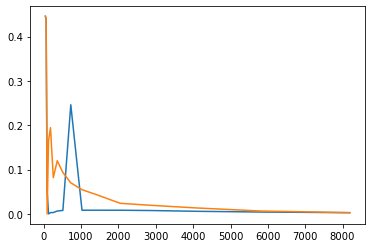

In [79]:
fig, ax = plt.subplots()
ax.plot(df_1["max_anchor_seen"], df_1["error"])
ax.plot(df_2["max_anchor_seen"], df_2["error"])